# Trying the model on our own handwritings

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import dataloader
import os
from PIL import Image

from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder

from torchvision.transforms import Compose, ToTensor, Lambda, Resize, Grayscale
from models import MyTransformer, MyVGG

In [2]:
def imshow(img, figsize=(4, 8)):
    npimg = np.array(img)
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

def print_decision(is_match):
    if is_match:
        print("Same writer")
    else:
        print("Different writer")

def transform():
    return Compose([
        ToTensor(),
        Lambda(lambda x: (torch.tile(x, (3,1)))),
        Grayscale(3),
        Resize((224, 224)),
    ])

Found 10 images in folder minimal_data


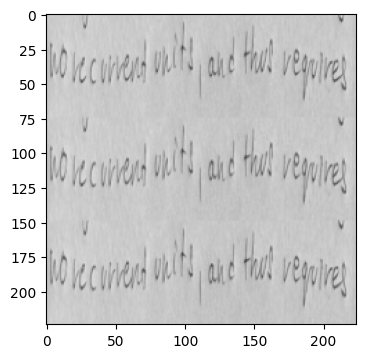

In [3]:
def read_images_from_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    images = []
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            img = Image.open(image_path).convert('RGB')
            images.append([transform()(img), int(image_file.split("_")[0])])
        except Exception as e:
            print(f"Error reading image '{image_file}': {e}")
    return images

folder_path = "minimal_data"
dataset = read_images_from_folder(folder_path)
print(f"Found {len(dataset)} images in folder {folder_path}")

imshow(dataset[2][0])

In [16]:
# model = MyTransformer()
# checkpoint = torch.load("model/with_transformer_grayscale_tiles_augment_only_on_train_night_60.pth")

model = MyVGG()
checkpoint = torch.load("model/with_vgg_20.pth")

model.load_state_dict(checkpoint)
model.to(torch.device("cuda"))
print("model loaded")

model loaded


In [17]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.8)
inference_model = InferenceModel(model, match_finder=match_finder)

inference_model.train_knn([x[0] for x in dataset])

In [23]:
good = 0

false_positive = 0
false_negative = 0

for x_image, x_writer in dataset:
    for y_image, y_writer in dataset:
        decision = inference_model.is_match(x_image.unsqueeze(0), y_image.unsqueeze(0), threshold=0.5)
        if (x_writer == y_writer and decision == True) or (x_writer != y_writer and decision == False):
            good += 1
        else:
            if decision == True:
                false_positive += 1
            else:
                false_negative += 1
                
print(false_positive, false_negative, good, false_positive+false_negative, good/(good+false_positive+false_negative))

2 14 84 16 0.84
